# Mapping Comparison via H₃⁺

This notebook compares different fermion-to-qubit mappings applied to the H₃⁺ molecule.
Each mapping is evaluated under the same ansatz (UCCSD) and optimizer (Adam).

We analyze:
- Qubit Hamiltonian complexity (Pauli term count),
- Energy convergence over 50 VQE iterations,
- Final ground state energy from each mapping.

Mappings compared:
- Jordan-Wigner (JW)
- Bravyi-Kitaev (BK)
- Parity

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt
import os

In [2]:
# Geometry of Trihydrogen Cation (non-degenerate to avoid symmetry trap)
symbols = ["H", "H", "H"]
coordinates = np.array([
    [ 0.000000,  1.000000,  0.000000],
    [-0.866025, -0.500000,  0.000000],
    [ 0.800000, -0.300000,  0.000000]  # slight distortion
])
electrons = 2

mappings = ["jordan_wigner", "bravyi_kitaev", "parity"]
hamiltonians = {}
qubits_required = {}

for mapping in mappings:
    H, qubits = qchem.molecular_hamiltonian(
        symbols,
        coordinates,
        charge=+1,
        mapping=mapping,
        active_electrons=electrons
    )
    hamiltonians[mapping] = H
    qubits_required[mapping] = qubits
    print(f"{mapping:>15}: {len(H)} Pauli terms with {qubits} qubits")

  jordan_wigner: 118 Pauli terms with 6 qubits
  bravyi_kitaev: 118 Pauli terms with 6 qubits
         parity: 118 Pauli terms with 6 qubits


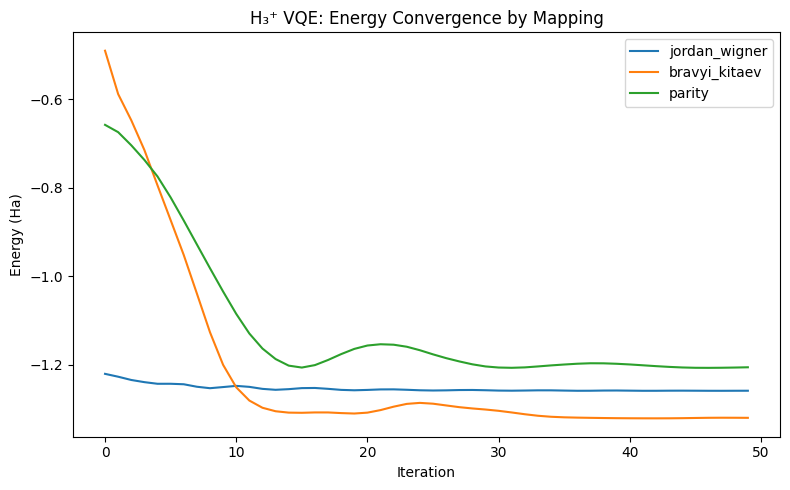

In [5]:
# Use Jordan-Wigner mapping qubit count as baseline
qubits = qubits_required["jordan_wigner"]
hf_state = qchem.hf_state(electrons, qubits)
singles, doubles = qchem.excitations(electrons, qubits)
singles = [tuple(s) for s in singles]
doubles = [tuple(d) for d in doubles]


def uccsd_ansatz(params, wires):
    i = 0
    qml.BasisState(hf_state, wires=wires)
    for ex in singles:
        qml.SingleExcitation(params[i], wires=ex)
        i += 1
    for ex in doubles:
        qml.DoubleExcitation(params[i], wires=ex)
        i += 1

max_iter = 50
results = {}

for mapping in mappings:
    dev = qml.device("default.qubit", wires=qubits)
    H = hamiltonians[mapping]

    @qml.qnode(dev)
    def circuit(params):
        uccsd_ansatz(params, wires=range(qubits))
        return qml.expval(H)

    n_params = len(singles) + len(doubles)
    params = np.random.normal(0, 0.1, size=n_params, requires_grad=True)
    opt = qml.AdamOptimizer(stepsize=0.2)

    energies = []
    for _ in range(max_iter):
        energies.append(circuit(params))
        params = opt.step(circuit, params)

    results[mapping] = energies

# Plot energy convergence
plt.figure(figsize=(8, 5))
for mapping in mappings:
    plt.plot(results[mapping], label=mapping)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₃⁺ VQE: Energy Convergence by Mapping")
plt.legend()
plt.tight_layout()
os.makedirs("images", exist_ok=True)
plt.savefig("images/H3+_Mapping_Comparison.png")
plt.show()

In [4]:
# Print final energies
print("\nFinal VQE Energies:")
for mapping in mappings:
    print(f"{mapping:>15}: {results[mapping][-1]:.8f} Ha")


Final VQE Energies:
  jordan_wigner: -1.25860509 Ha
  bravyi_kitaev: -1.31943557 Ha
         parity: -1.20493135 Ha
